In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima 
from statsmodels.tsa.seasonal import seasonal_decompose 
import pmdarima as pm
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

from utils import mape, media_e2, PSM, PSV, PC_

In [2]:
## Relevant paths of current project

path_code = os.getcwd()
path_project = os.path.split(path_code)[0]
path_data = os.path.join(path_project, "data")

## Read raw data

df_raw_data = pd.read_csv(path_data + "\\Datos_Prueba_DataScientist.csv")
df_raw_data["RequestTime"] = pd.to_datetime(df_raw_data["RequestTime"], format = '%Y/%m/%d %H:%M:%S')

In [3]:
df_raw_data

OrderId         RequestTime  \
0            PED_1 2018-01-01 08:03:12   
1            PED_2 2018-01-01 08:28:55   
2            PED_3 2018-01-01 08:39:08   
3            PED_4 2018-01-01 09:25:07   
4            PED_5 2018-01-01 09:36:25   
...            ...                 ...   
153270  PED_153271 2021-02-28 17:19:26   
153271  PED_153272 2021-02-28 17:19:37   
153272  PED_153273 2021-02-28 17:43:56   
153273  PED_153274 2021-02-28 17:53:28   
153274  PED_153275 2021-02-28 17:53:41   

                                   DeliveryOption  
0               Mismo dia entre 6:30 pm y 8:30 pm  
1               Mismo dia entre 6:30 pm y 8:30 pm  
2               Mismo dia entre 6:30 pm y 8:30 pm  
3          Siguiente dia entre 12:30 pm y 2:30 pm  
4          Siguiente dia entre 12:30 pm y 2:30 pm  
...                                           ...  
153270     Siguiente dia entre 12:30 pm y 2:30 pm  
153271     Siguiente dia entre 12:30 pm y 2:30 pm  
153272  Siguiente dia entre las 6:30 pm y 8:30 pm  
153273  Siguiente dia entre las 6:30 pm y 8:30 pm  
153274     Siguiente dia entre 12:30 pm y 2:30 pm  

[153275 rows x 3 columns]

## Particularities of delivery

Based on regulatory conditions, the orders could only be enlisted at certain shifts, regarding the option of delivery the customer choosed. To organized the data, I will create another variables, $\text{enlisted\_time}$ to determined when each order will be delivered. The enlistment follows the next based-rule conditions

* All orders $Option1$ will be delivered the same day at 6:00pm
* All orders $Option2$ will be delivered the next day at 12:00pm
* All orders $Option3$ will be delivered the next day at 6:00pm

Another think that must be considered, is the case when a 

* Customer choose $Option1$ but after 12pm, in this case I considered to deliver the order in the next departure (next day at 12:00pm)

In [4]:
options = np.sort(df_raw_data["DeliveryOption"].unique())
opt1 = options[0]
opt2 = options[1]
opt3 = options[2]

In [5]:
list_deli_hour =[]

for cont in range(len(df_raw_data)):
    hour_order = df_raw_data.iloc[cont, 1].hour
    opt_order = df_raw_data.iloc[cont, 2]

    if hour_order < 12 and opt_order == opt1:
        deli_hour = df_raw_data.iloc[cont, 1] + pd.DateOffset(days = 0, hour = 18, minute = 0, second = 0)
        list_deli_hour.append(deli_hour)

    if hour_order >= 12 and opt_order == opt1:
        deli_hour = df_raw_data.iloc[cont, 1] + pd.DateOffset(days = 1, hour = 12, minute = 0, second = 0)
        list_deli_hour.append(deli_hour)

    if opt_order == opt2:
        deli_hour = df_raw_data.iloc[cont, 1] + pd.DateOffset(days = 1, hour = 12, minute = 0, second = 0)
        list_deli_hour.append(deli_hour)

    if opt_order == opt3:
        deli_hour = df_raw_data.iloc[cont, 1] + pd.DateOffset(days = 1, hour = 18, minute = 0, second = 0)
        list_deli_hour.append(deli_hour)
    
df_raw_data["enlisted_time"] = list_deli_hour
df_raw_data

OrderId         RequestTime  \
0            PED_1 2018-01-01 08:03:12   
1            PED_2 2018-01-01 08:28:55   
2            PED_3 2018-01-01 08:39:08   
3            PED_4 2018-01-01 09:25:07   
4            PED_5 2018-01-01 09:36:25   
...            ...                 ...   
153270  PED_153271 2021-02-28 17:19:26   
153271  PED_153272 2021-02-28 17:19:37   
153272  PED_153273 2021-02-28 17:43:56   
153273  PED_153274 2021-02-28 17:53:28   
153274  PED_153275 2021-02-28 17:53:41   

                                   DeliveryOption       enlisted_time  
0               Mismo dia entre 6:30 pm y 8:30 pm 2018-01-01 18:00:00  
1               Mismo dia entre 6:30 pm y 8:30 pm 2018-01-01 18:00:00  
2               Mismo dia entre 6:30 pm y 8:30 pm 2018-01-01 18:00:00  
3          Siguiente dia entre 12:30 pm y 2:30 pm 2018-01-02 12:00:00  
4          Siguiente dia entre 12:30 pm y 2:30 pm 2018-01-02 12:00:00  
...                                           ...                 ...  
153270     Siguiente dia entre 12:30 pm y 2:30 pm 2021-03-01 12:00:00  
153271     Siguiente dia entre 12:30 pm y 2:30 pm 2021-03-01 12:00:00  
153272  Siguiente dia entre las 6:30 pm y 8:30 pm 2021-03-01 18:00:00  
153273  Siguiente dia entre las 6:30 pm y 8:30 pm 2021-03-01 18:00:00  
153274     Siguiente dia entre 12:30 pm y 2:30 pm 2021-03-01 12:00:00  

[153275 rows x 4 columns]

Once that I have the time when each order will be departure, I will split the database between the orders that will be attend by morning pickers from the afternoon pickers

In [6]:
df_morning_pickers = df_raw_data.loc[df_raw_data["enlisted_time"].dt.hour == 12]
df_afternoon_pickers = df_raw_data.loc[df_raw_data["enlisted_time"].dt.hour == 18]

Now, I am trying to solve the next question, determine the optimum number of workers per shift that only change once a month (I will assume that this change will occur at the beginning of the month). This number will be ruled by the maximum amount of orders that must be delivered on every shift (12 pm or 18). 

Why not by the minimum? Let's consider that on every shift at least 30 orders must be prepared. The optimum number of workers that I need (and have to fulfill the condition that every picker must prepare at least 5 orders/hour) is just 1 picker. But is the same result if 30 orders came, or 100 or 20000. That is known as a corner solution, and because of that is why I have to consider a maximum number of orders per hour (MXNOPH) that a picker could attend on an hour. 

But that creates another problem/issue. If I have a condition of MXNOPH equals to 10 and at the same time there is another condition that refers that all orders must be delivered, in case that on certain shift 1200 orders came, I will need 20 pickers to accomplish this orders, but if on the next shift only 120 orders came, each picker will have an average of 1 order per hour.

On the other hand, I could model the minimum number of orders that on certain shift came on certain month without consider a MXNOPH, and guarantee that the minimun number of order per picker per hour will be 5, but as we could see at next, the volatility or change between the number of order between 2 consecutive day is that high, that on certain day 1 picker could prepare 5 order per hour on average and the next day could prepare twice that number. Because of that, on this analysis, must be assumed that a picker could duplicated its capacity without affect the fulfillment of every order. 

## Analysis guaranting that minimum work ratio of 5 orders picked per hour will be achieved.

To accomplished this, I will model the minimun orders that came per shift on certain month. The reason to model the minimum on a monthly resolutions is that I could change the amount of picker once on a month (at the beginning). First, let's take a look of how behavies the number of orders that came every single day on morning shift

Text(0.5, 0, 'Date')

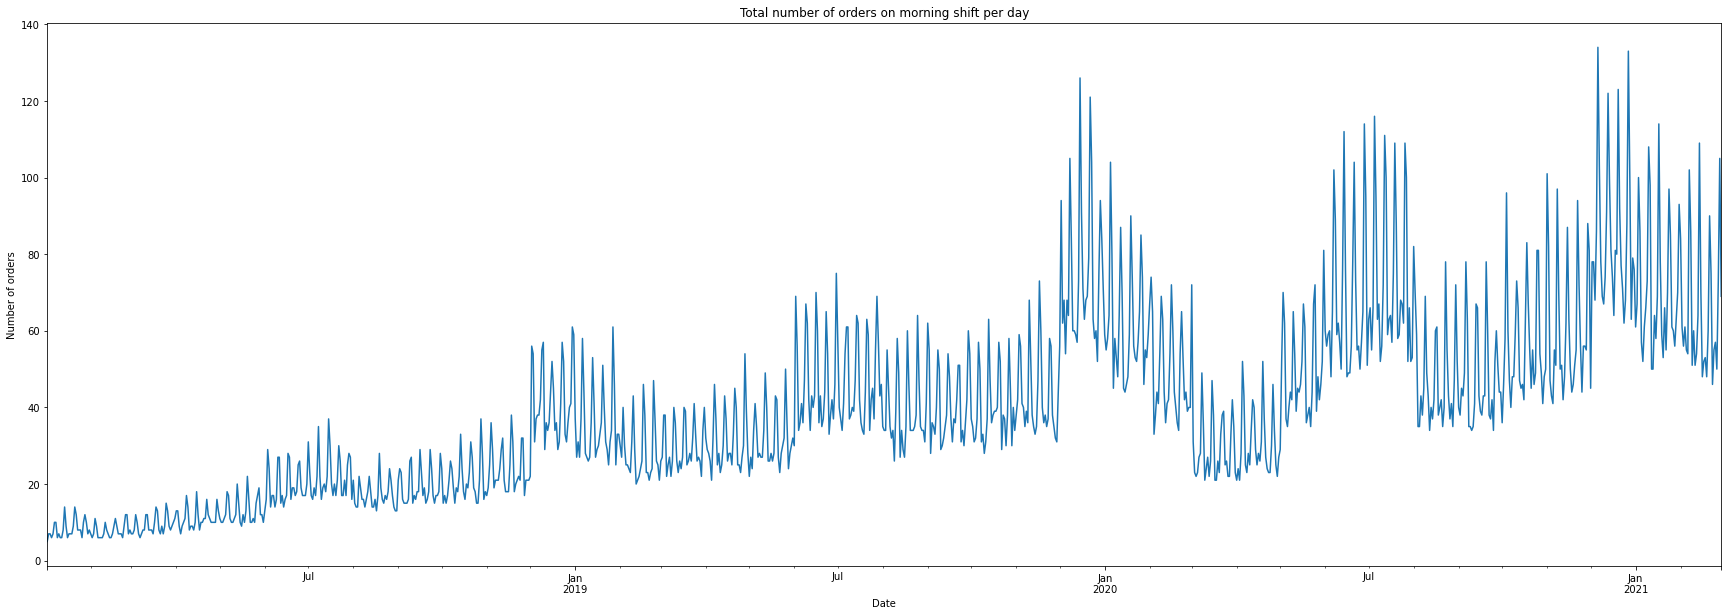

In [7]:
ax = df_morning_pickers.resample("D", on = "enlisted_time").count()["OrderId"].plot(figsize = (30,10), title = "Total number of orders on morning shift per day")
ax.set_ylabel("Number of orders")
ax.set_xlabel("Date")

Text(0.5, 0, 'Date')

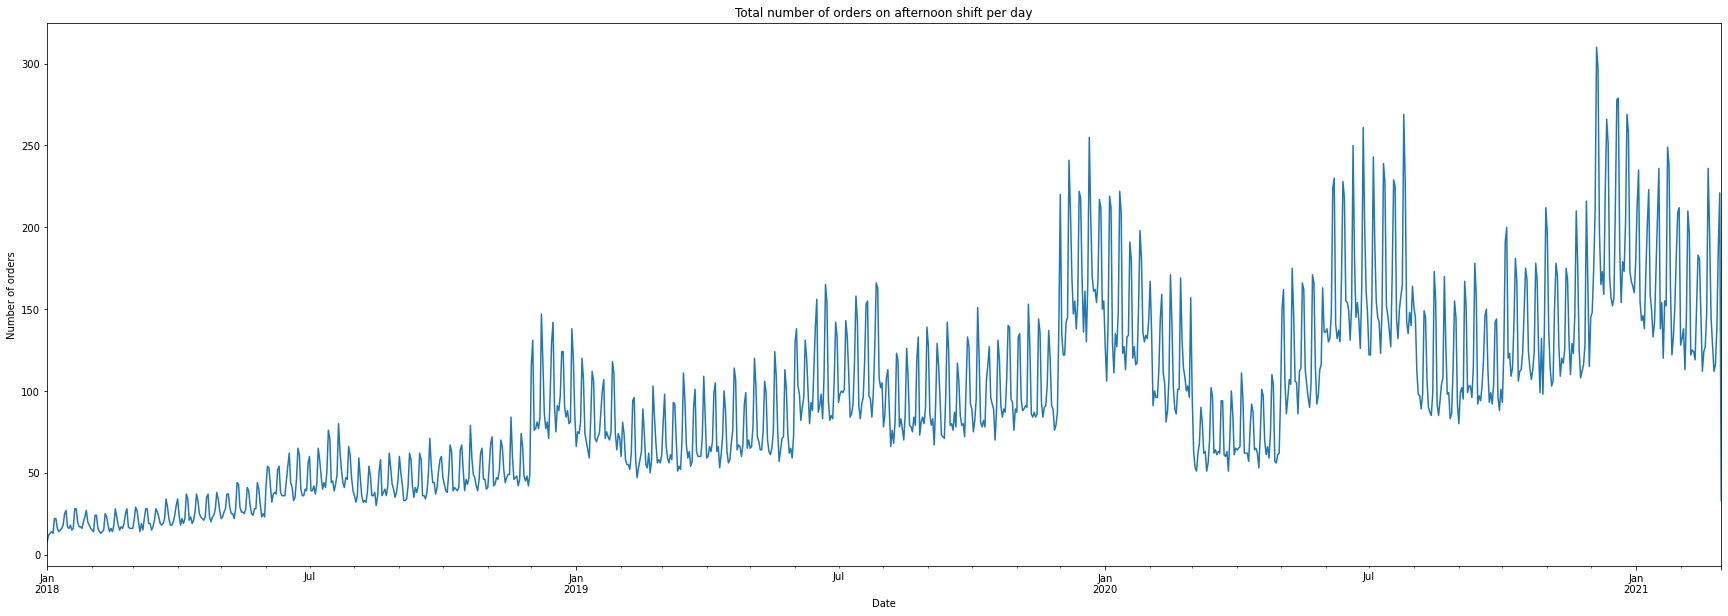

In [8]:
ax = df_afternoon_pickers.resample("D", on = "enlisted_time").count()["OrderId"].plot(figsize = (30,10), title = "Total number of orders on afternoon shift per day")
ax.set_ylabel("Number of orders")
ax.set_xlabel("Date")

As we could see, both time series present a very well defined long term tendency and a increase of volatility on levels. Further, I will transform these time series using a Box Cox Transformation, to reduce the impact of this effect.

$$Z_{t}^{(\lambda)}=\left\{\begin{array}{lll}
\frac{Z_{t}^{\lambda}-1}{\lambda} & \text { if } & \lambda \neq 0 \\
\ln \left(Z_{t}\right) & \text { if } & \lambda=0
\end{array}\right.$$

where $\lambda$ is the transformation parameter.

In [9]:
df_number_orders_morning = df_morning_pickers.resample("D", on = "enlisted_time").count()["OrderId"].to_frame()
df_number_orders_morning.columns = [["number_orders"]]
df_number_orders_afternoon = df_afternoon_pickers.resample("D", on = "enlisted_time").count()["OrderId"].to_frame()
df_number_orders_afternoon.columns = [["number_orders"]]

df_number_orders_morning["number_order_trans"], lambda_morning = boxcox(df_number_orders_morning["number_orders"].values.reshape([len(df_number_orders_morning)]))
df_number_orders_afternoon["number_order_trans"], lambda_after = boxcox(df_number_orders_afternoon["number_orders"].values.reshape([len(df_number_orders_afternoon)]))

Text(0.5, 0, 'Date')

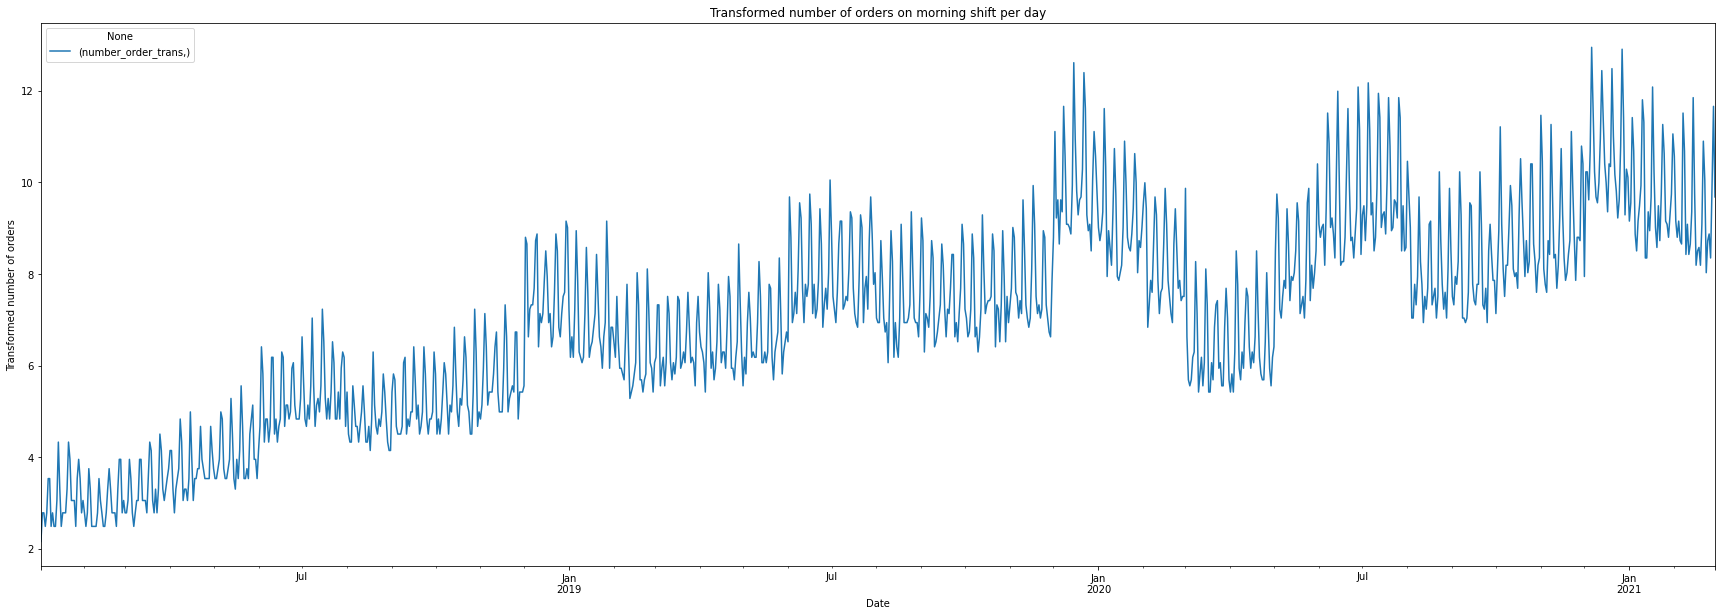

In [10]:
ax = df_number_orders_morning["number_order_trans"].plot(figsize = (30,10), title = "Transformed number of orders on morning shift per day")
ax.set_ylabel("Transformed number of orders")
ax.set_xlabel("Date")

Text(0.5, 0, 'Date')

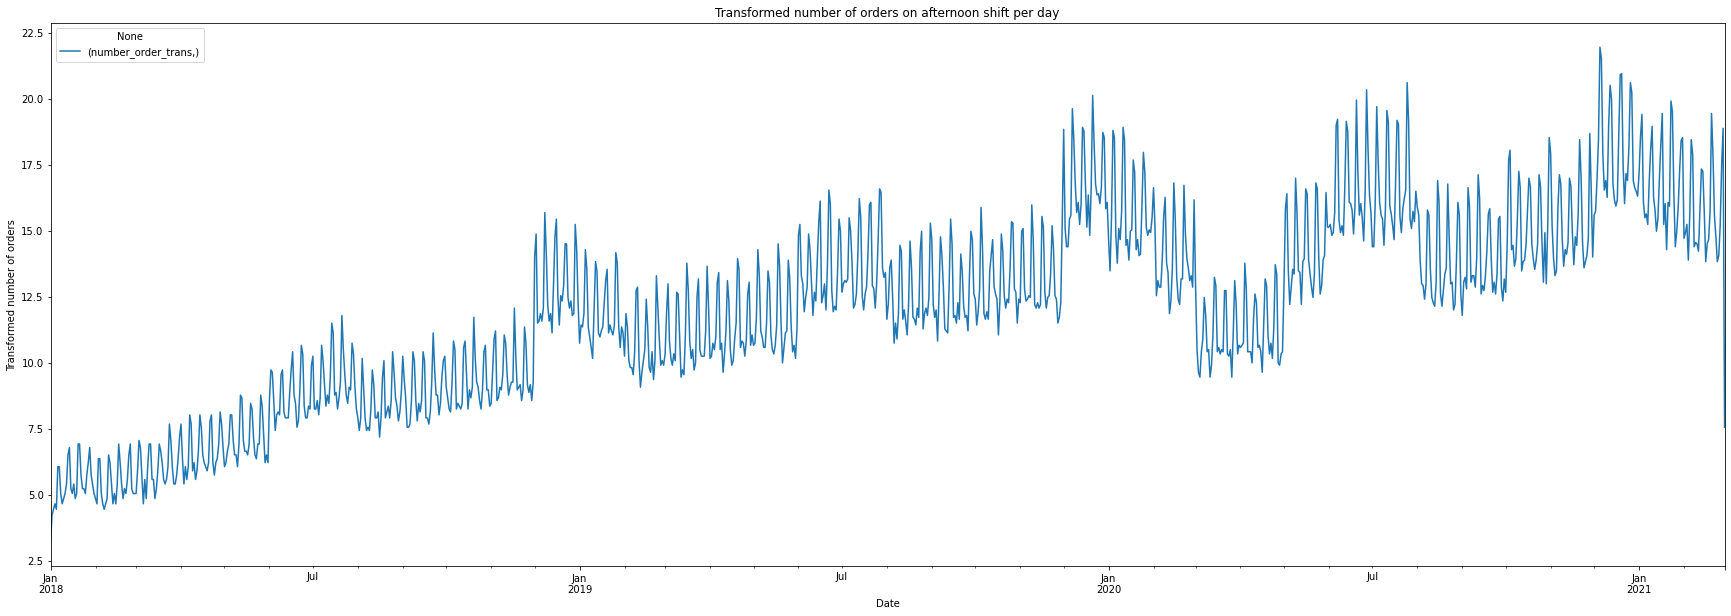

In [11]:
ax = df_number_orders_afternoon["number_order_trans"].plot(figsize = (30,10), title = "Transformed number of orders on afternoon shift per day")
ax.set_ylabel("Transformed number of orders")
ax.set_xlabel("Date")

These are the time series that I will model, reducing the impact of the volatility, to increace the chances to obtain robust models. There could be better estimations to $\lambda$ parameter, but this one is a good approx.

Once that I have the final time series, could be a very intuitive way to obtain information, if I try to split the time series on a Seasonal and Tendency part. But first, let's take a look on a ADF test, to determine if these time series are stationary or not (I am pretty sure that they do not).

In [12]:
rows =[]
df_both = df_number_orders_afternoon.join(df_number_orders_morning, rsuffix = "_morning", lsuffix = "_afternoon")[["number_order_trans_morning", "number_order_trans_afternoon"]].dropna()
for count,dataset_name in enumerate(df_both.columns):
    row = [dataset_name]
    time_series = df_both[dataset_name]
    result = adfuller(time_series)
    row.extend([result[0],result[1]])
    row.extend([value for key, value in result[4].items()])
    rows.append(row)
    
pd.DataFrame(rows,columns=['Dataset','Statistic ADF','p-value','Cr. Val. 1%','Cr. Val. 5%','Cr. Val. 10%'])

Dataset  Statistic ADF   p-value  Cr. Val. 1%  \
0    (number_order_trans_morning,)      -1.844212  0.358743    -3.436145   
1  (number_order_trans_afternoon,)      -2.175719  0.215176    -3.436140   

   Cr. Val. 5%  Cr. Val. 10%  
0    -2.864099     -2.568132  
1    -2.864097     -2.568131

In [13]:
rows =[]
df_both_diff = df_number_orders_afternoon.join(df_number_orders_morning, rsuffix = "_morning_diff", lsuffix = "_afternoon_diff")[["number_order_trans_morning_diff", "number_order_trans_afternoon_diff"]].dropna().diff().dropna()
for count,dataset_name in enumerate(df_both_diff.columns):
    row = [dataset_name]
    time_series = df_both_diff[dataset_name]
    result = adfuller(time_series)
    row.extend([result[0],result[1]])
    row.extend([value for key, value in result[4].items()])
    rows.append(row)
    
pd.DataFrame(rows,columns=['Dataset','Statistic ADF','p-value','Cr. Val. 1%','Cr. Val. 5%','Cr. Val. 10%'])

Dataset  Statistic ADF       p-value  \
0    (number_order_trans_morning_diff,)      -7.460792  5.360789e-11   
1  (number_order_trans_afternoon_diff,)      -6.668997  4.639019e-09   

   Cr. Val. 1%  Cr. Val. 5%  Cr. Val. 10%  
0    -3.436145    -2.864099     -2.568132  
1    -3.436140    -2.864097     -2.568131

Because at different critical values (1%, 5% and 10%) we are not able to reject the null hypothesis, there could be some time-dependent structure on the time series. Once that I differenciate the time series, we achieve under multiple critical values to reject the Ho, so we got stationary series. We continue continue with the seasonal analysis.

Next, by means of a decomposition in trend and seasonality, we determine if with periods of 7, 30 and 60 days if there is any seasonality but more important that the trend is constant, since it is one of the criteria for the series to be stationary. This decomposition, which is done under Fourier transforms, can be performed assuming two types of models:

* Additive modelo

$$Z_{t}^{(\lambda)} = T_{t} + S_{t} + e_{t}$$

* Multiplicative model

$$Z_{t}^{(\lambda)} = T_{t} * S_{t} + e_{t}$$

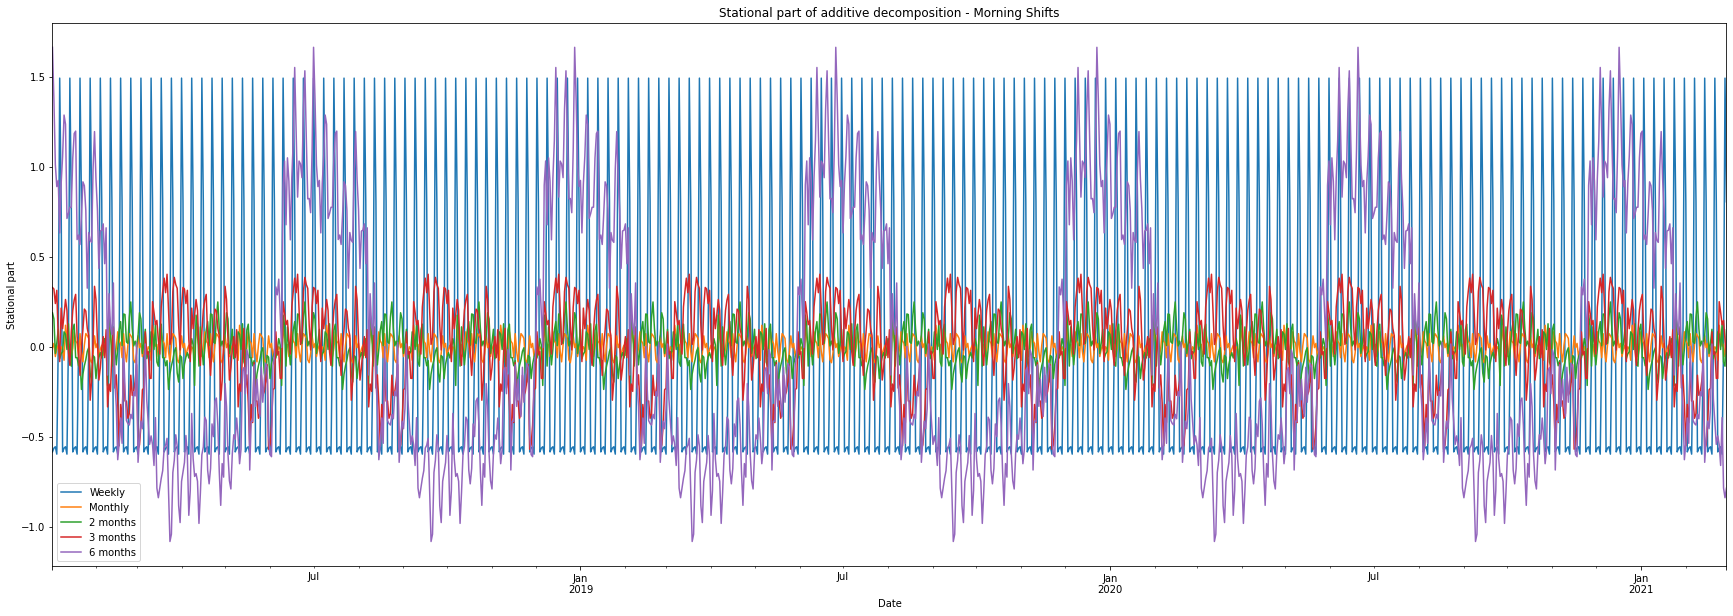

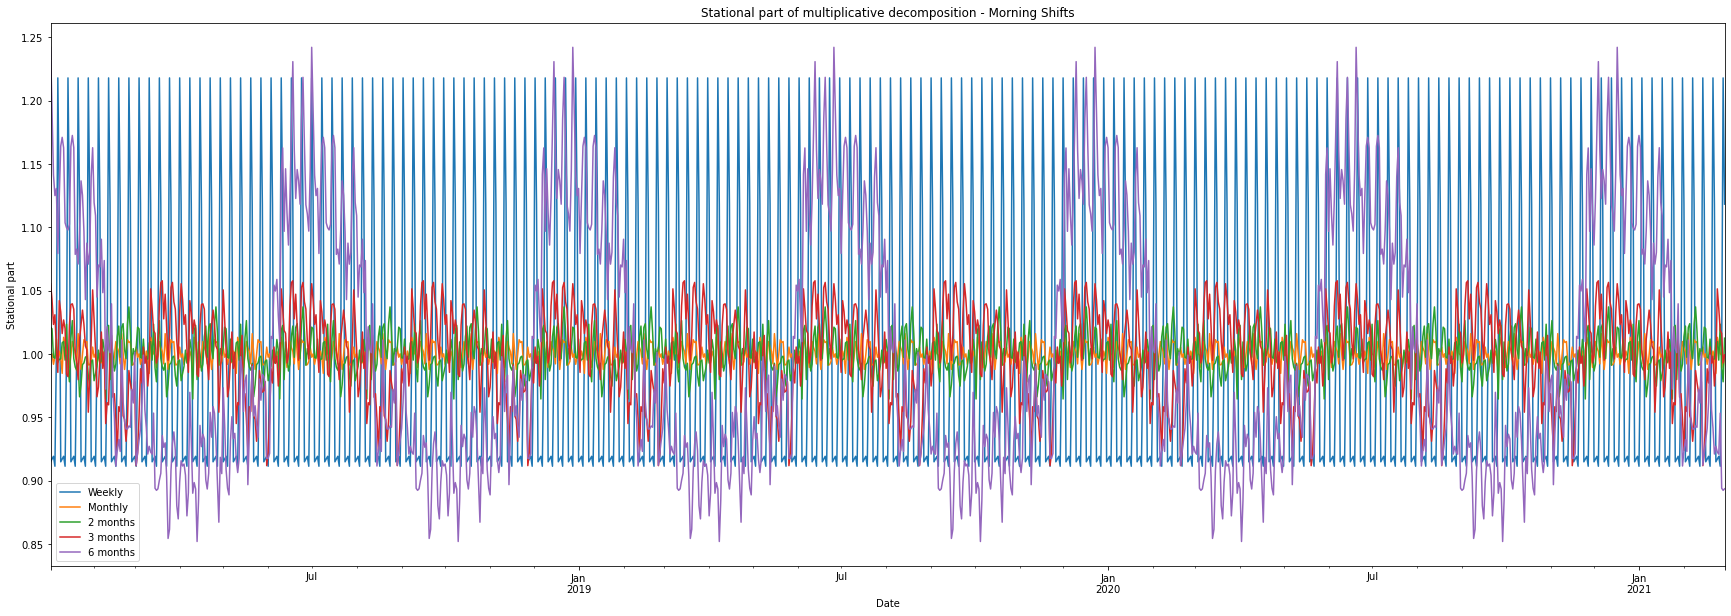

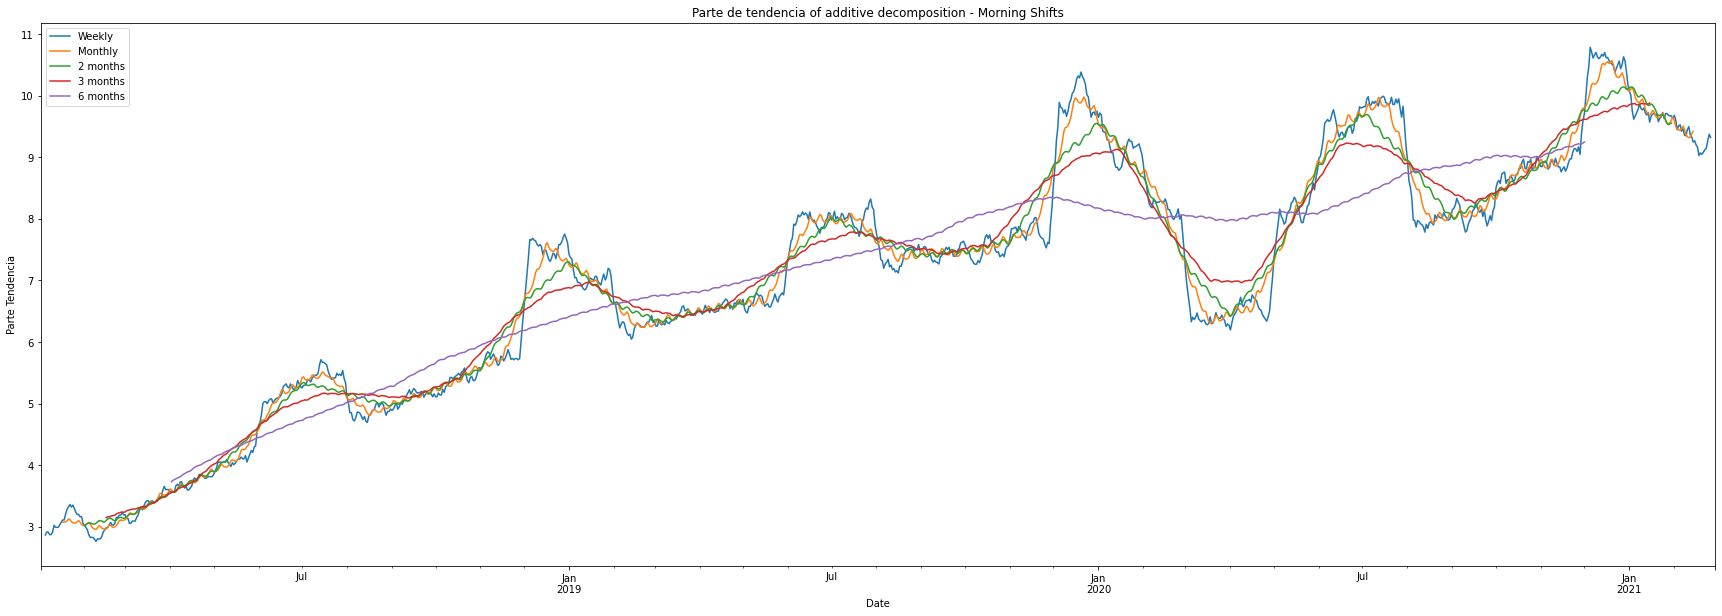

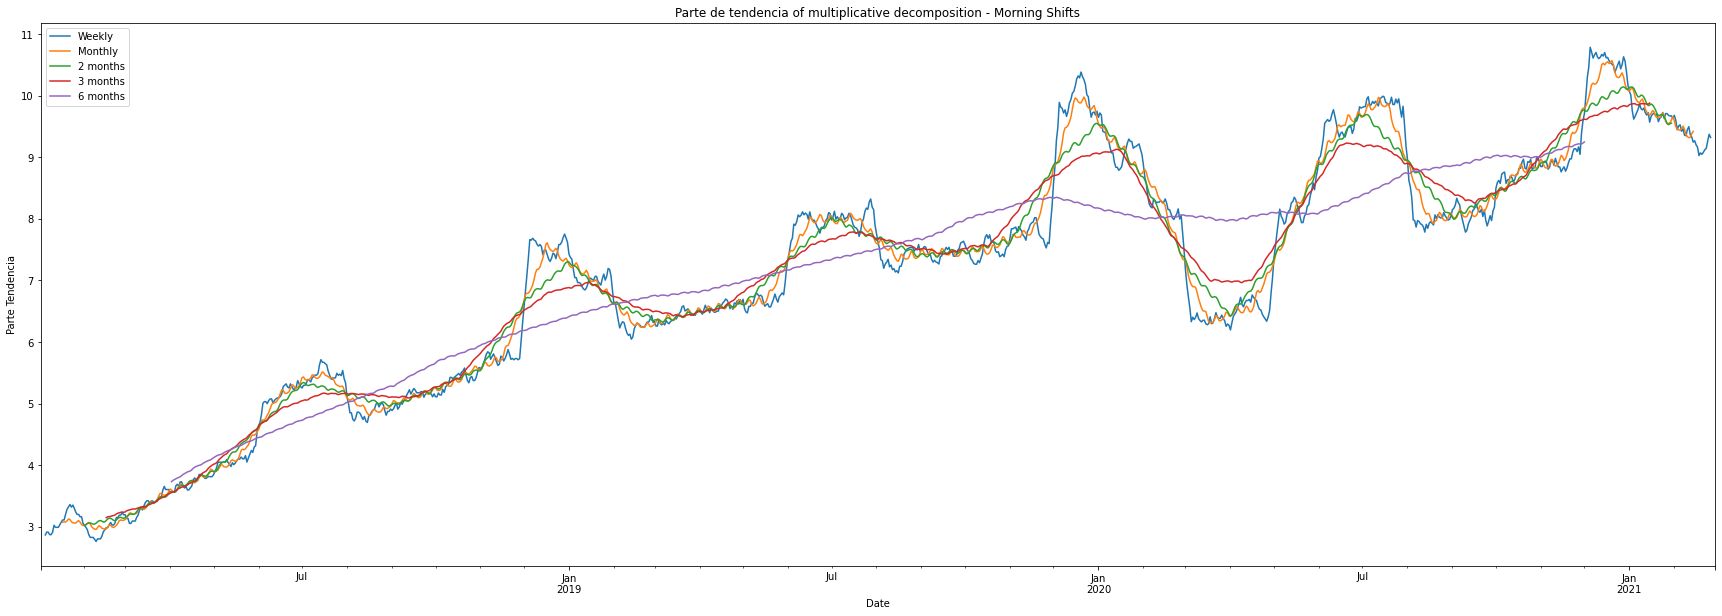

In [14]:
# We perform different additive decompositions
df_both_morning_add_sem = seasonal_decompose(df_both['number_order_trans_morning'], model = "add", period = 7)
df_both_morning_add_mens = seasonal_decompose(df_both['number_order_trans_morning'], model = "add", period = 30)
df_both_morning_add_bimes = seasonal_decompose(df_both['number_order_trans_morning'], model = "add", period = 60)
df_both_morning_add_quat = seasonal_decompose(df_both['number_order_trans_morning'], model = "add", period = 90)
df_both_morning_add_semes = seasonal_decompose(df_both['number_order_trans_morning'], model = "add", period =180)

# We perform different multiplicative decompositions
df_both_morning_mult_sem = seasonal_decompose(df_both['number_order_trans_morning'], model = "mult", period = 7)
df_both_morning_mult_mens = seasonal_decompose(df_both['number_order_trans_morning'], model = "mult", period = 30)
df_both_morning_mult_bimes = seasonal_decompose(df_both['number_order_trans_morning'], model = "mult", period = 60)
df_both_morning_mult_quat = seasonal_decompose(df_both['number_order_trans_morning'], model = "mult", period = 90)
df_both_morning_mult_semes = seasonal_decompose(df_both['number_order_trans_morning'], model = "mult", period = 180)

# We plot the seasonal part by additive decomposition
plt.figure(figsize = (30,10))
ax_sea_add = df_both_morning_add_sem.seasonal.plot(label = 'Weekly');
ax_sea_add = df_both_morning_add_mens.seasonal.plot(label = 'Monthly');
ax_sea_add = df_both_morning_add_bimes.seasonal.plot(label = '2 months');
ax_sea_add = df_both_morning_add_quat.seasonal.plot(label = '3 months');
ax_sea_add = df_both_morning_add_semes.seasonal.plot(label = '6 months');
ax_sea_add.set(xlabel='Date', ylabel='Stational part');
ax_sea_add.set_title('Stational part of additive decomposition - Morning Shifts')
ax_sea_add.legend()

# We plot the seasonal part by multiplicative decomposition
plt.figure(figsize = (30,10))
ax_sea_mult = df_both_morning_mult_sem.seasonal.plot(label = 'Weekly');
ax_sea_mult = df_both_morning_mult_mens.seasonal.plot(label = 'Monthly');
ax_sea_mult = df_both_morning_mult_bimes.seasonal.plot(label = '2 months');
ax_sea_mult = df_both_morning_mult_quat.seasonal.plot(label = '3 months');
ax_sea_mult = df_both_morning_mult_semes.seasonal.plot(label = '6 months');
ax_sea_mult.set(xlabel='Date', ylabel='Stational part');
ax_sea_mult.set_title('Stational part of multiplicative decomposition - Morning Shifts')
ax_sea_mult.legend()

# We plot the trend portion by additive decomposition
plt.figure(figsize = (30,10))
ax_trend_add = df_both_morning_add_sem.trend.plot(label = 'Weekly');
ax_trend_add = df_both_morning_add_mens.trend.plot(label = 'Monthly');
ax_trend_add = df_both_morning_add_bimes.trend.plot(label = '2 months');
ax_trend_add = df_both_morning_add_quat.trend.plot(label = '3 months');
ax_trend_add = df_both_morning_add_semes.trend.plot(label = '6 months');
ax_trend_add.set(xlabel='Date', ylabel='Parte Tendencia');
ax_trend_add.set_title('Parte de tendencia of additive decomposition - Morning Shifts')
ax_trend_add.legend()

# We plot the trend part by multiplicative decomposition
plt.figure(figsize = (30,10))
ax_trend_mult = df_both_morning_mult_sem.trend.plot(label = 'Weekly');
ax_trend_mult = df_both_morning_mult_mens.trend.plot(label = 'Monthly');
ax_trend_mult = df_both_morning_mult_bimes.trend.plot(label = '2 months');
ax_trend_mult = df_both_morning_mult_quat.trend.plot(label = '3 months');
ax_trend_mult = df_both_morning_mult_semes.trend.plot(label = '6 months');
ax_trend_mult.set(xlabel='Date', ylabel='Parte Tendencia');
ax_trend_mult.set_title('Parte de tendencia of multiplicative decomposition - Morning Shifts')
ax_trend_mult.legend()

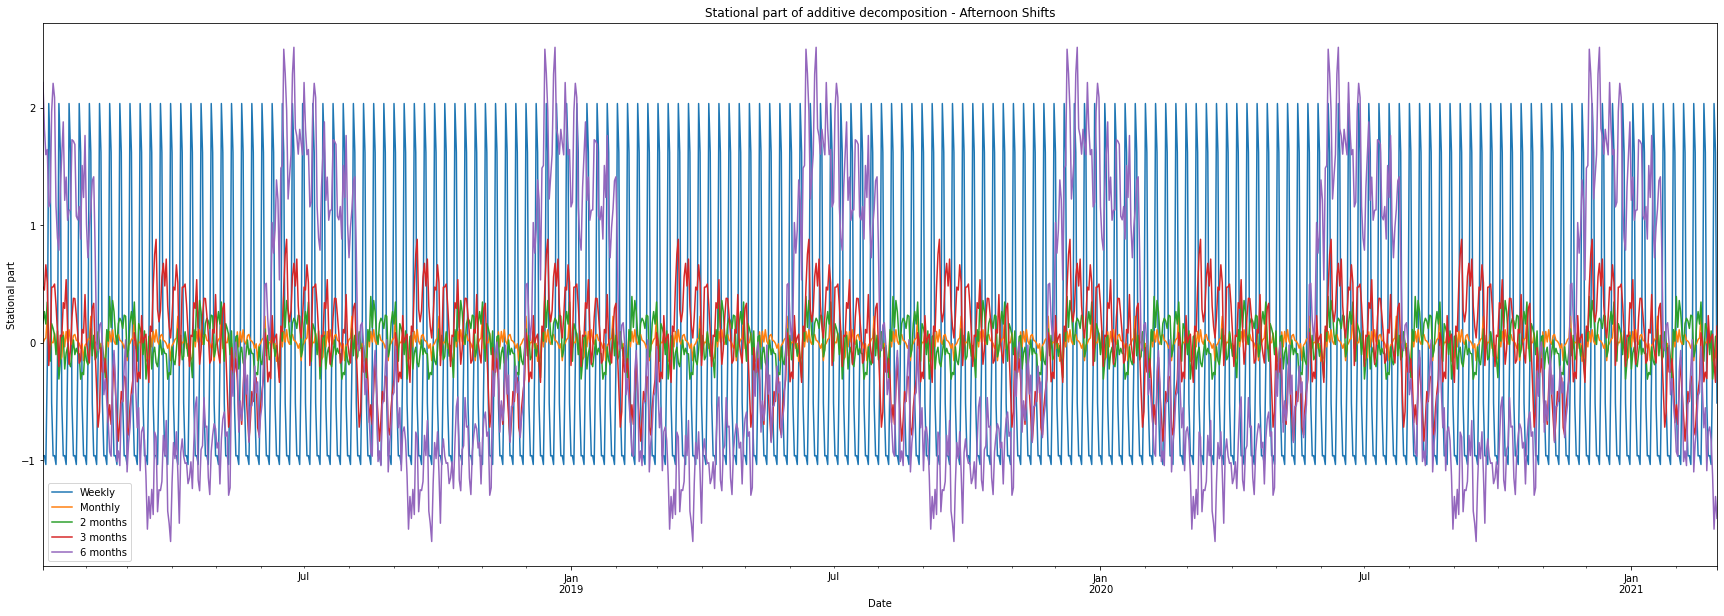

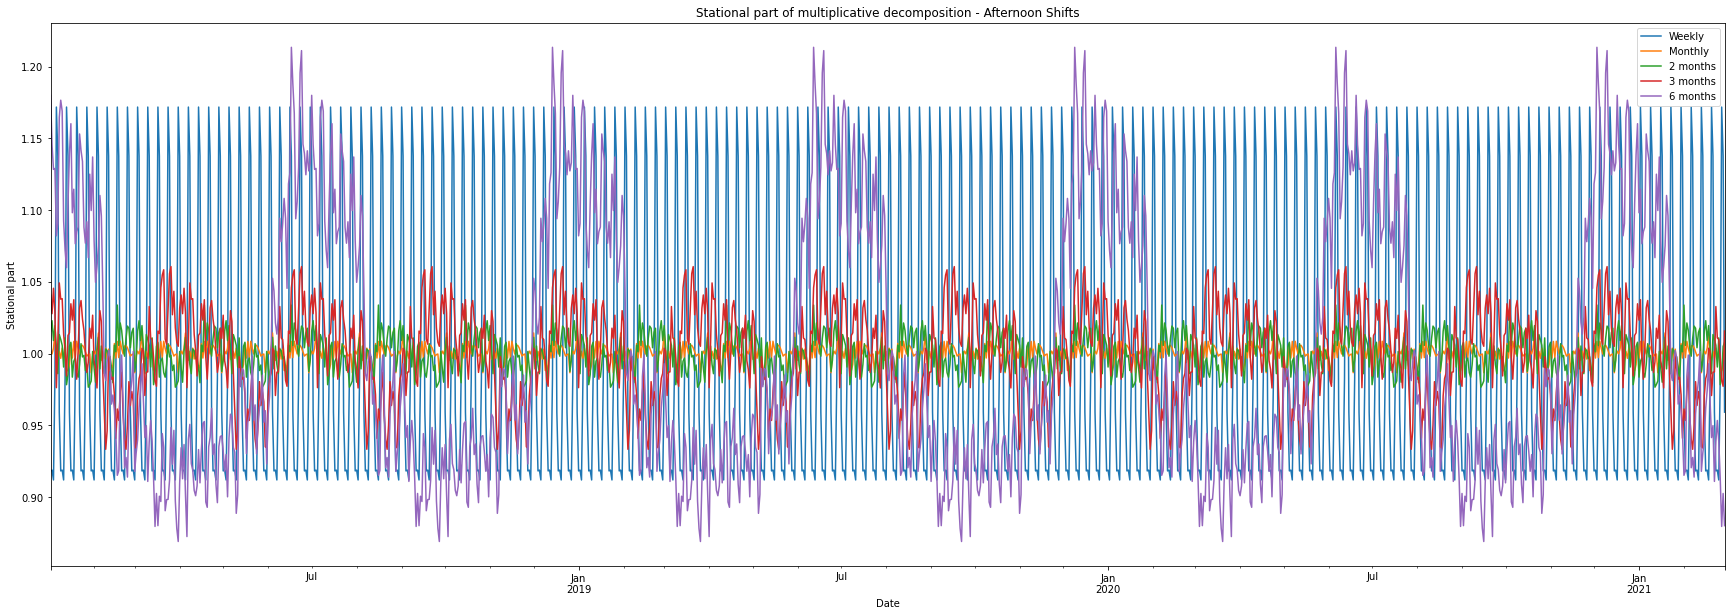

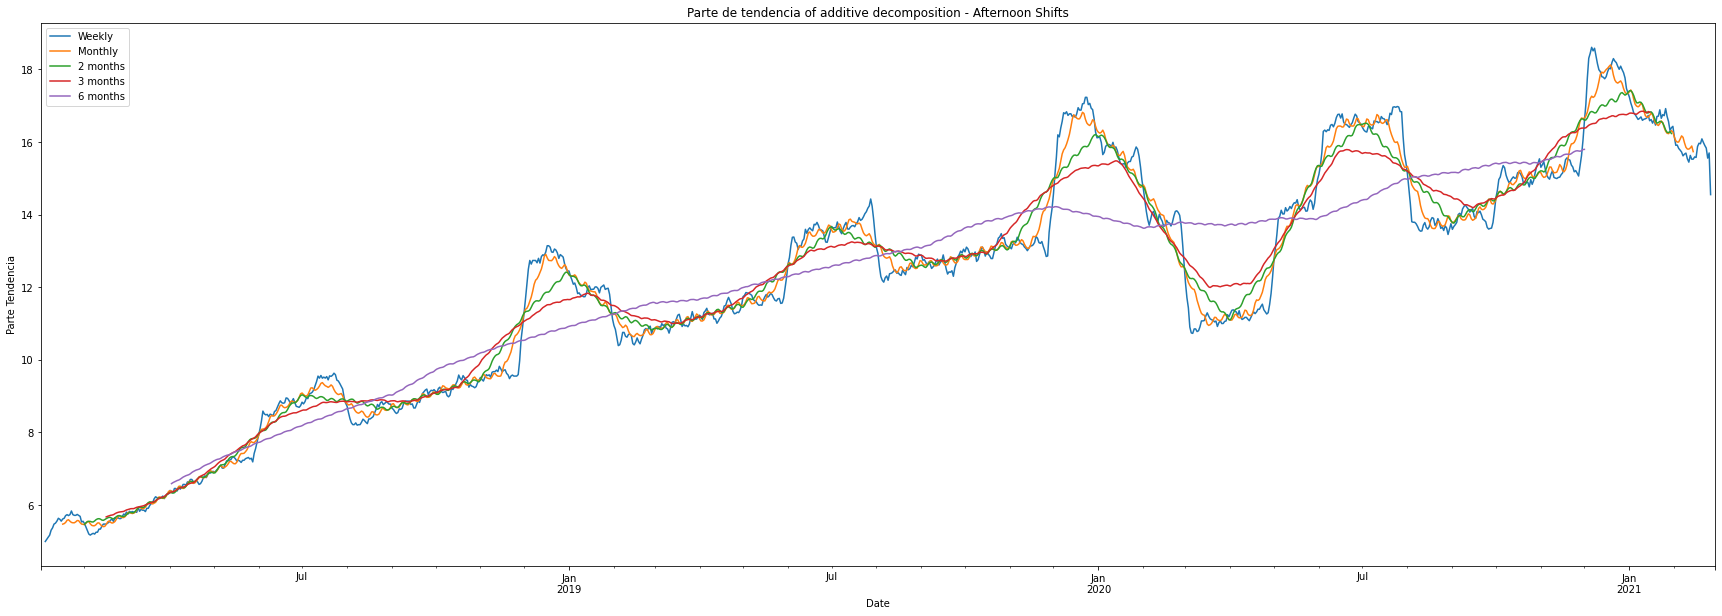

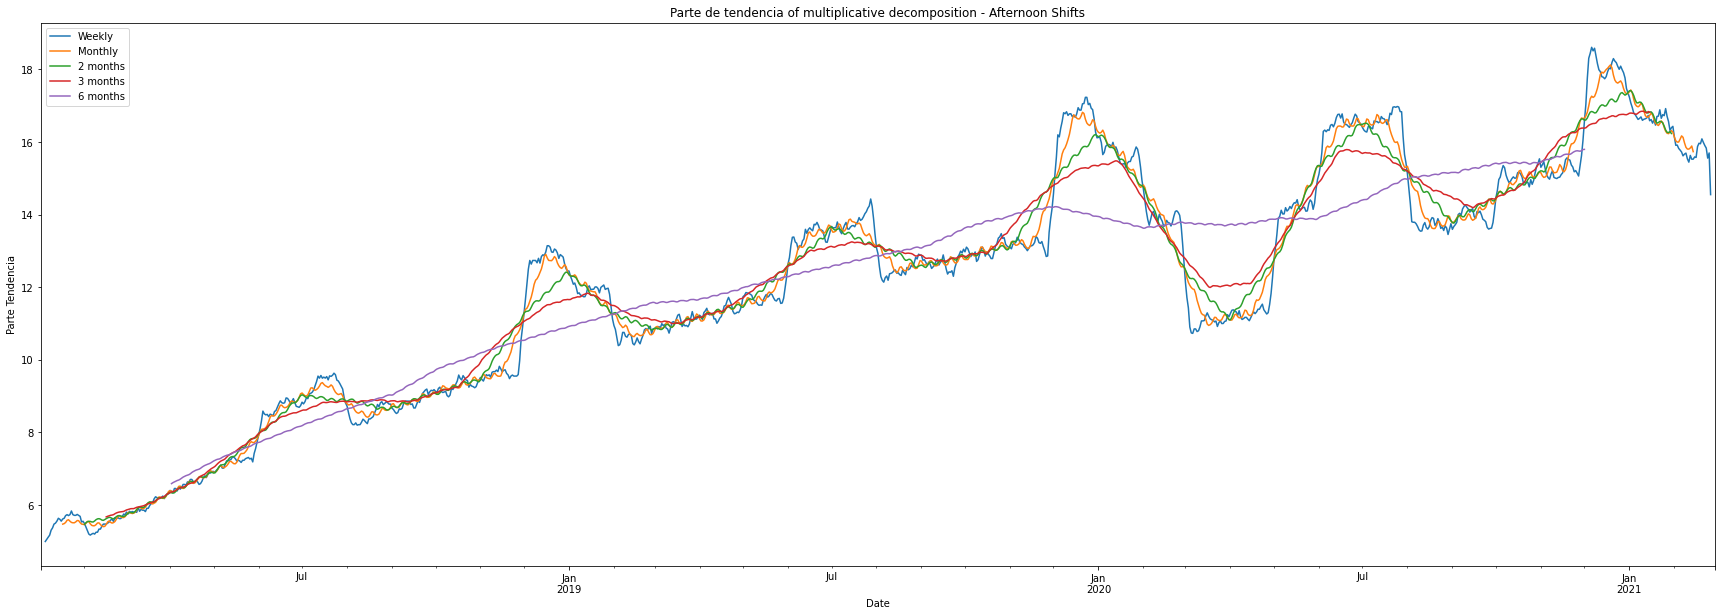

In [15]:
# We perform different additive decompositions
df_both_afternoon_add_sem = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "add", period = 7)
df_both_afternoon_add_mens = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "add", period = 30)
df_both_afternoon_add_bimes = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "add", period = 60)
df_both_afternoon_add_quat = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "add", period = 90)
df_both_afternoon_add_semes = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "add", period =180)

# We perform different multiplicative decompositions
df_both_afternoon_mult_sem = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "mult", period = 7)
df_both_afternoon_mult_mens = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "mult", period = 30)
df_both_afternoon_mult_bimes = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "mult", period = 60)
df_both_afternoon_mult_quat = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "mult", period = 90)
df_both_afternoon_mult_semes = seasonal_decompose(df_both['number_order_trans_afternoon'], model = "mult", period = 180)

# We plot the seasonal part by additive decomposition
plt.figure(figsize = (30,10))
ax_sea_add = df_both_afternoon_add_sem.seasonal.plot(label = 'Weekly');
ax_sea_add = df_both_afternoon_add_mens.seasonal.plot(label = 'Monthly');
ax_sea_add = df_both_afternoon_add_bimes.seasonal.plot(label = '2 months');
ax_sea_add = df_both_afternoon_add_quat.seasonal.plot(label = '3 months');
ax_sea_add = df_both_afternoon_add_semes.seasonal.plot(label = '6 months');
ax_sea_add.set(xlabel='Date', ylabel='Stational part');
ax_sea_add.set_title('Stational part of additive decomposition - Afternoon Shifts')
ax_sea_add.legend()

# We plot the seasonal part by multiplicative decomposition
plt.figure(figsize = (30,10))
ax_sea_mult = df_both_afternoon_mult_sem.seasonal.plot(label = 'Weekly');
ax_sea_mult = df_both_afternoon_mult_mens.seasonal.plot(label = 'Monthly');
ax_sea_mult = df_both_afternoon_mult_bimes.seasonal.plot(label = '2 months');
ax_sea_mult = df_both_afternoon_mult_quat.seasonal.plot(label = '3 months');
ax_sea_mult = df_both_afternoon_mult_semes.seasonal.plot(label = '6 months');
ax_sea_mult.set(xlabel='Date', ylabel='Stational part');
ax_sea_mult.set_title('Stational part of multiplicative decomposition - Afternoon Shifts')
ax_sea_mult.legend()

# We plot the trend portion by additive decomposition
plt.figure(figsize = (30,10))
ax_trend_add = df_both_afternoon_add_sem.trend.plot(label = 'Weekly');
ax_trend_add = df_both_afternoon_add_mens.trend.plot(label = 'Monthly');
ax_trend_add = df_both_afternoon_add_bimes.trend.plot(label = '2 months');
ax_trend_add = df_both_afternoon_add_quat.trend.plot(label = '3 months');
ax_trend_add = df_both_afternoon_add_semes.trend.plot(label = '6 months');
ax_trend_add.set(xlabel='Date', ylabel='Parte Tendencia');
ax_trend_add.set_title('Parte de tendencia of additive decomposition - Afternoon Shifts')
ax_trend_add.legend()

# We plot the trend part by multiplicative decomposition
plt.figure(figsize = (30,10))
ax_trend_mult = df_both_afternoon_mult_sem.trend.plot(label = 'Weekly');
ax_trend_mult = df_both_afternoon_mult_mens.trend.plot(label = 'Monthly');
ax_trend_mult = df_both_afternoon_mult_bimes.trend.plot(label = '2 months');
ax_trend_mult = df_both_afternoon_mult_quat.trend.plot(label = '3 months');
ax_trend_mult = df_both_afternoon_mult_semes.trend.plot(label = '6 months');
ax_trend_mult.set(xlabel='Date', ylabel='Parte Tendencia');
ax_trend_mult.set_title('Parte de tendencia of multiplicative decomposition - Afternoon Shifts')
ax_trend_mult.legend()

The previous results show 2 issues.

* There is a seasonal effect with a weekly periodicity (period of 7 days).
* There is a seasonal effect with a semestral periodicity (period of 180 days).

Both periodicities are obtain based on the amount of volatility this periods are able to capture on the additive and multiplicative structures, and how stables are the tendency terms.

Other implication of this analisys, is how the change of tendency due the pandemic might not be statistically suffient. To test this hypothesis we could realized an event-based study.

Another method that can be used to determine if there is a deterministic seasonal structure in the time series is to perform a Buys-Ballot analysis, which consists in giving a seasonal period $S$, organize the data in such a way that it is possible to identify if there is any pattern between seasonal periods. Next I present this analysis with the same periods 7, 30, 60, 90 and 180 days with the intention of identifying if between these periods there is any relationship.


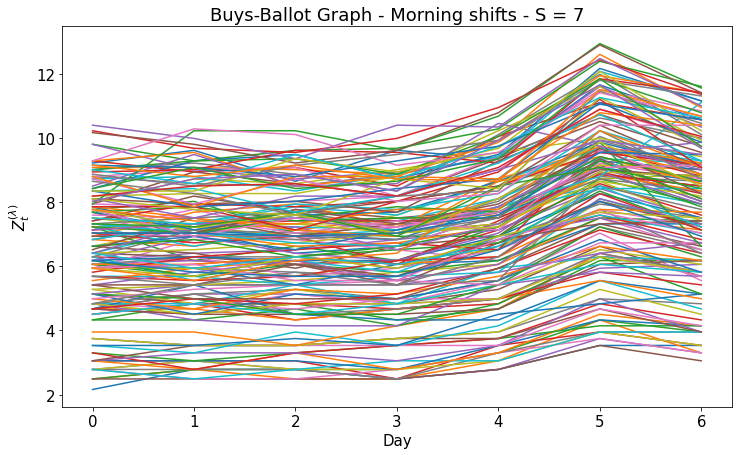

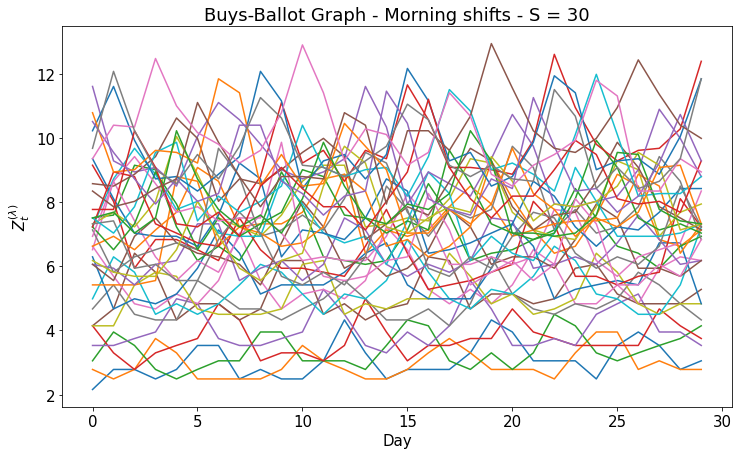

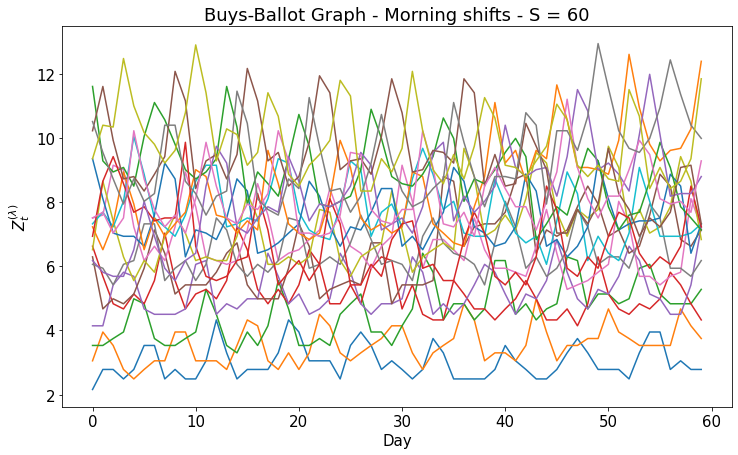

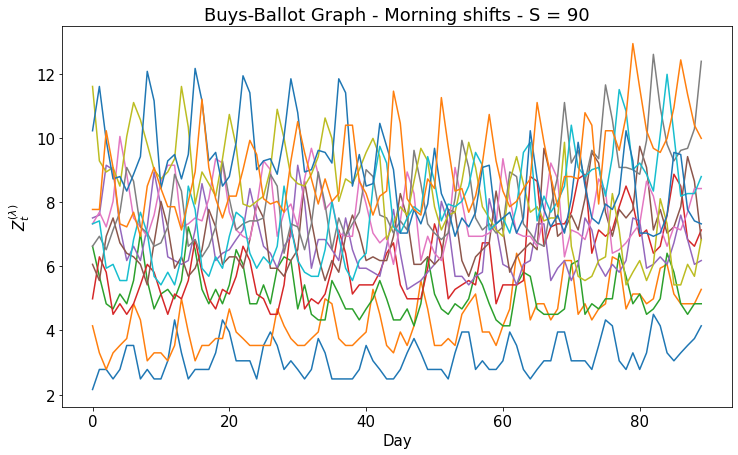

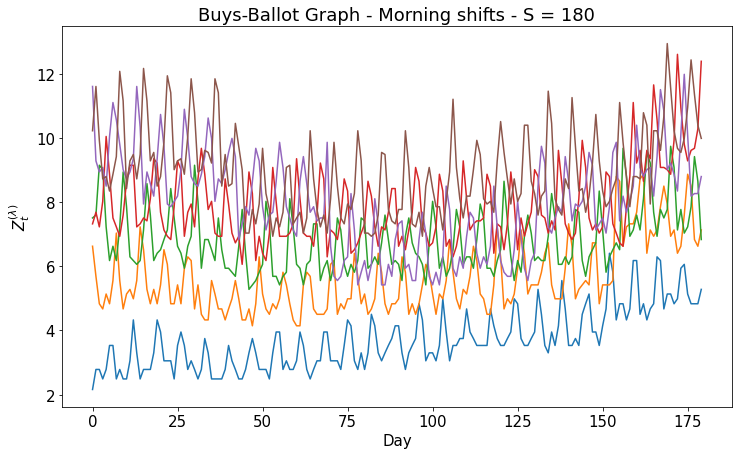

In [16]:
season = [7, 30, 60, 90, 180]
plt.rcParams.update({'font.size': 15})
for index, j in enumerate(season):
    seasons = int(len(df_both['number_order_trans_morning']) / j)
    for i in range(int(seasons/1)):
        temp = df_both['number_order_trans_morning'][i*j:(i+1)*j].to_numpy()
        plt.figure(index, figsize = (12, 7))
        plt.plot(temp)
        plt.xlabel('Day')
        plt.ylabel('$Z_{t}^{(\lambda)}$')
        plt.title('Buys-Ballot Graph - Morning shifts - S = ' + str(j))
plt.show()

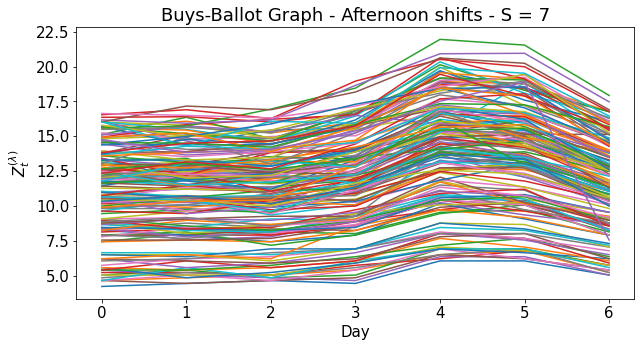

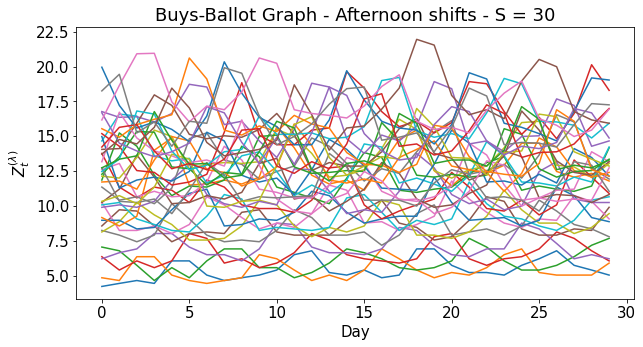

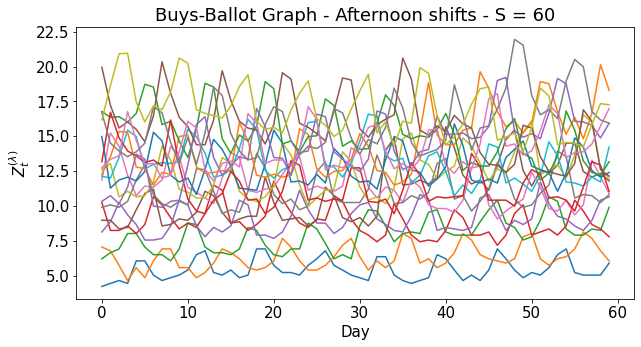

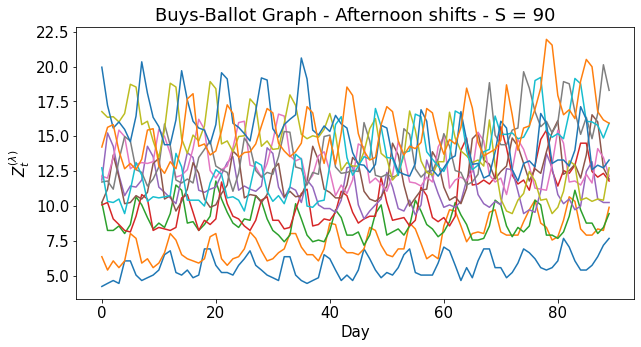

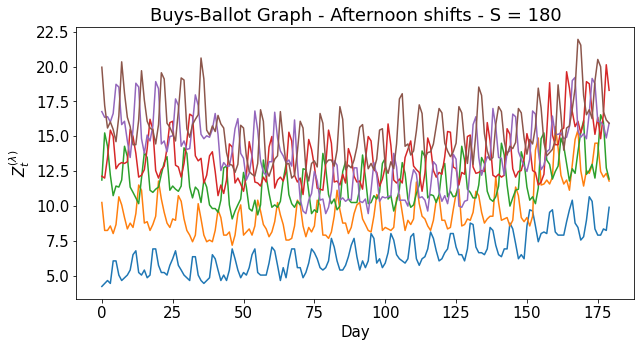

In [17]:
season = [7, 30, 60, 90, 180]
plt.rcParams.update({'font.size': 15})
for index, j in enumerate(season):
    seasons = int(len(df_both['number_order_trans_afternoon']) / j)
    for i in range(int(seasons/1)):
        temp = df_both['number_order_trans_afternoon'][i*j:(i+1)*j].to_numpy()
        plt.figure(index, figsize = (10, 5))
        plt.plot(temp)
        plt.xlabel('Day')
        plt.ylabel('$Z_{t}^{(\lambda)}$')
        plt.title('Buys-Ballot Graph - Afternoon shifts - S = ' + str(j))
plt.show()

Despite the level, we could appreciated on the $S=7\text{ days}$ how on days 4 and 5 (friday and saturday) the orders on both shifts increase respect the rest of the week.

## Estimation of Autoregressive and Seasonal Moving Average Models SARIMA(p,d,q)x(P,D,Q)s

These models have the following structure:

$$
\Phi_{P}\left(B^{S}\right) \phi_{p}(B)(1-B)^{d}\left(1-B^{S}\right)^{D} \dot{Z}_{t}=\theta_{q}(B) \Theta_{Q}\left(B^{S}\right) a_{t}
$$

where,

$$
\dot{Z}_{t}=\left\{\begin{array}{ll}
Z_{t}-\mu & \text { if } d=D=0 \\
Z_{t} & \text { otherwise }
\end{array}\right.
$$


$\mathrm{A} \quad \phi_{p}(B)$ and $\theta_{q}(B)$ are called the polynomial $(\mathrm{o}$ factors $)$ autoregressive $\mathrm{y}$ of regular or ordinary moving averages, respectively, 
and $\Phi_{P}\left(B^{S}\right)$ and $\Theta_{Q}\left(B^{S}\right)$ are called the autoregressive and seasonal moving average polynomials (or factors) $(1) and $(2).
(1-B)$ is the first regular or ordinary difference and $$(1-B^{S}right)$ is the first seasonal difference (Castaño, 2001).
seasonal difference (Castaño, 2019), with $B$ being the lag operator.

To analyze this model, some restrictions on the parameter values must be made.

* For the parameter $p$, of the ordinary autoregressive part the following interval is proposed, mainly because the model itself is a short memory model, usually these models do not use more than 5 lags.

$$ p \in [0,3]$$

* On the side of the $q$ parameter of the ordinary moving average part the same principle applies, so the interval is

$$ q \in [0,3]$$

* For the case of $d$, which is the integration parameter of the ordinary time series, given the ADF result, which suggests that there is no unit root

$$ d \in [0]$$

* For the parameter $P$, of the seasonal autoregressive part, the following interval is proposed, mainly because of the significance of some factors in the PACF, where there are two groups that are statistically significant at 5%.

$$ P \in [0,1]$$

* For the $Q$ parameter, of the seasonal moving average part, the following interval is proposed, mainly because of the behavior of the ACF, where 2 clusters of lags statistically significant at 5% are also identified

$$Q \in [0,1]$$

* Regarding the number of times the seasonal trend part should be integrated, in general a time series only needs to be differenced once to become stationary, so the following interval is assumed

$$ D \in [0,1]$$

* Finally, to determine the lags over which to analyze the stationarity, the following values are proposed, which correspond to the analyses performed previously plus the case of no seasonal component

$$S \in \{1, 7, 180\}$$

To estimate this model we will use the pmdarima library, using the $\text{auto\_arima}$ function. On the other hand, taking into account the restrictions of the forecast, where it is required to estimate the next 300 days for the variable of interest, methodologies to validate the structure of a model such as "Rolling Window" are not the most accurate to identify which model has the best performance. Therefore, the first stage will consist of estimating the model with the entire database and selecting under the Bayerian information criterion (BIC) since this is more robust to overfitting the models. The search for the best model will be done with the use of the $stepwise$ function which is based on the work of Hyndman and Khandakar (2008). After this we will test the models for each seasonality. For this case we will use the first 70% data (training set) to estimate the next 30% data (test set). Due to the high computational cost, I do not estimate 180 days lag.




In [19]:
# Model estimation Morning shift
arima_models_morning = []
season_arima = [1, 7]
for index, val in enumerate(season_arima):
    arima_models_morning.append(auto_arima(df_both['number_order_trans_morning'], seasonal=True, stationary=True, m=val, start_p = 0, max_p=2, d = 0,
                                   start_q = 0, max_q=2, start_P = 0, max_P=1, start_D = 0, max_D=1, start_Q = 0,
                                   max_Q=1, stepwise=True, information_criterion='bic'))
    print('We got a model for a stationality of {} days - Morning shitf'.format(season_arima[index]))

We got a model for a stationality of 1 days - Morning shitf
We got a model for a stationality of 7 days - Morning shitf


In [20]:
# Model estimation Afternoon Shift
arima_models_afternoon = []
season_arima = [1, 7]
for index, val in enumerate(season_arima):
    arima_models_afternoon.append(auto_arima(df_both['number_order_trans_afternoon'], seasonal=True, stationary=True, m=val, start_p = 0, max_p=2, d = 0,
                                   start_q = 0, max_q=2, start_P = 0, max_P=1, start_D = 0, max_D=1, start_Q = 0,
                                   max_Q=1, stepwise=True, information_criterion='bic'))
    print('We got a model for a stationality of {} days - Afternoon shitf'.format(season_arima[index]))


We got a model for a stationality of 1 days - Afternoon shitf
We got a model for a stationality of 7 days - Afternoon shitf


In [21]:
for i in range(len(arima_models_morning)):
    print(arima_models_morning[i].summary())
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1155
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -1409.690
Date:                Sun, 01 May 2022   AIC                           2827.379
Time:                        21:54:41   BIC                           2847.587
Sample:                             0   HQIC                          2835.006
                               - 1155                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   3063.276      0.000       0.999       1.000
ma.L1         -0.2996      0.027    -11.229      0.000      -0.352      -0.247
ma.L2         -0.5414      0.024    -22.574      0.0

In [22]:
for i in range(len(arima_models_afternoon)):
    print(arima_models_afternoon[i].summary())
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1155
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1870.291
Date:                Sun, 01 May 2022   AIC                           3750.582
Time:                        21:54:41   BIC                           3775.841
Sample:                             0   HQIC                          3760.115
                               - 1155                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1897      0.051     23.349      0.000       1.090       1.290
ar.L2         -0.1898      0.051     -3.723      0.000      -0.290      -0.090
ma.L1         -0.3390      0.041     -8.346      0.0

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


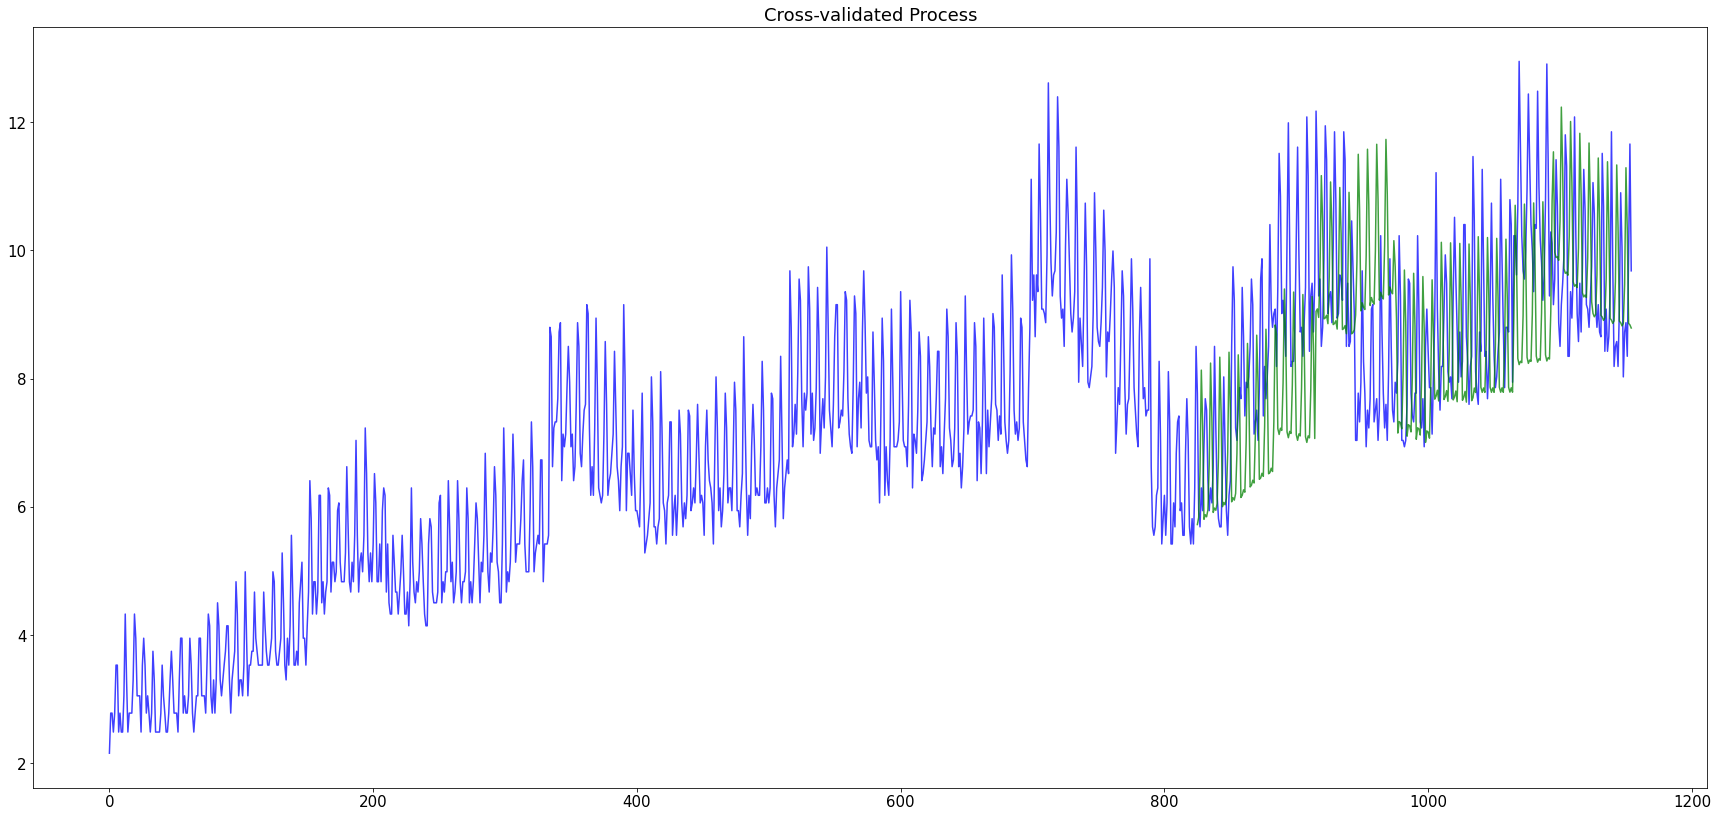

In [29]:
# Model Training Morning S = 7
est_1 = pm.ARIMA(order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 7),
                  suppress_warnings=True)
cv_1 = model_selection.SlidingWindowForecastCV(window_size=800, step=30, h=30)
predictions_1 = model_selection.cross_val_predict(
    est_1, df_both['number_order_trans_morning'], cv=cv_1, verbose=2, averaging="median")

x_axis = np.arange(len(df_both['number_order_trans_morning']))
n_test = predictions_1.shape[0]

plt.figure(figsize = (30,14))
plt.plot(x_axis, df_both['number_order_trans_morning'], alpha=0.75, c='b', label = 'Real Data')
plt.plot(x_axis[-n_test:], predictions_1, alpha=0.75, c='g', label = 'Forecast')  # Forecasts
plt.title("Cross-validated Process")
plt.show()

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................


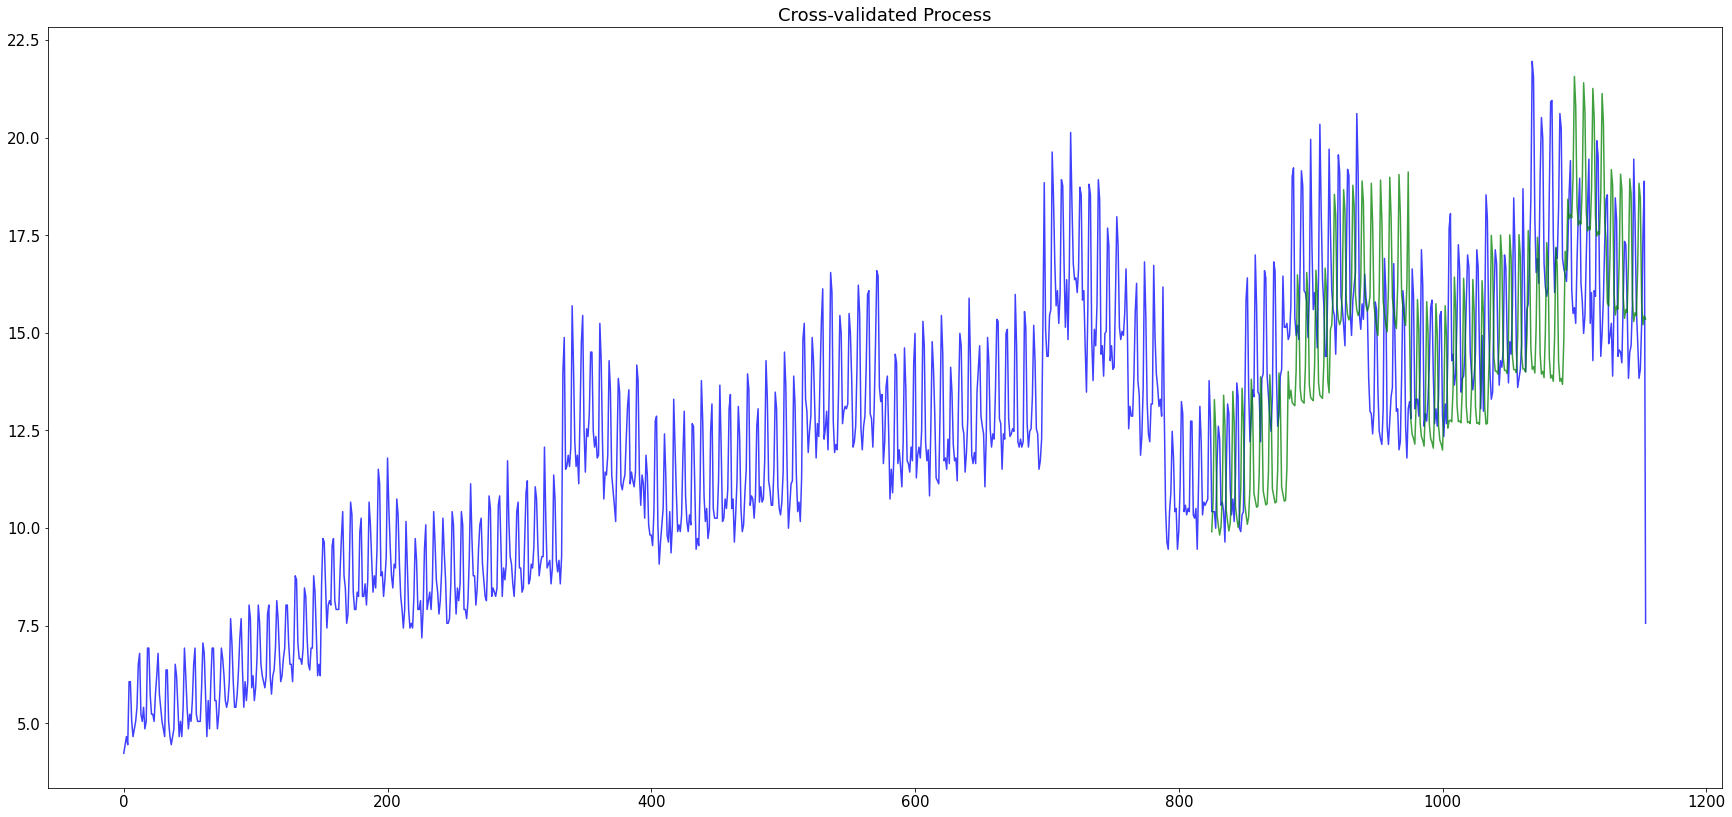

In [30]:
# Model Training Afternoon S = 7
est_1 = pm.ARIMA(order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 7),
                  suppress_warnings=True)
cv_1 = model_selection.SlidingWindowForecastCV(window_size=800, step=30, h=30)
predictions_1 = model_selection.cross_val_predict(
    est_1, df_both['number_order_trans_afternoon'], cv=cv_1, verbose=2, averaging="median")

x_axis = np.arange(len(df_both['number_order_trans_afternoon']))
n_test = predictions_1.shape[0]

plt.figure(figsize = (30,14))
plt.plot(x_axis, df_both['number_order_trans_afternoon'], alpha=0.75, c='b', label = 'Real Data')
plt.plot(x_axis[-n_test:], predictions_1, alpha=0.75, c='g', label = 'Forecast')  # Forecasts
plt.title("Cross-validated Process")
plt.show()

In [ ]:
# A continuación obtengo las medidas de error para cada modelo
    
# Fila para el modelo sin estacionalidad
rows_model =[]
row_model = [str(arima_models[0])]
row_model.extend([mape(fp_mix['fp ave'][501:], predictions_1)])
row_model.extend([media_e2(fp_mix['fp ave'][501:], predictions_1)])
row_model.extend([PSM(fp_mix['fp ave'][501:], predictions_1)])
row_model.extend([PSV(fp_mix['fp ave'][501:], predictions_1)])
row_model.extend([PC_(fp_mix['fp ave'][501:], predictions_1)])
rows_model.append(row_model)

# Fila para el modelo de 7 días de estacionalidad
row_model = [str(arima_models[1])]
row_model.extend([mape(fp_mix['fp ave'][501:], predictions_7)])
row_model.extend([media_e2(fp_mix['fp ave'][501:], predictions_7)])
row_model.extend([PSM(fp_mix['fp ave'][501:], predictions_7)])
row_model.extend([PSV(fp_mix['fp ave'][501:], predictions_7)])
row_model.extend([PC_(fp_mix['fp ave'][501:], predictions_7)])
rows_model.append(row_model)

# Fila para el modelo de 30 días de estacionalidad
row_model = [str(arima_models[2])]
row_model.extend([mape(fp_mix['fp ave'][501:], predictions_30)])
row_model.extend([media_e2(fp_mix['fp ave'][501:], predictions_30)])
row_model.extend([PSM(fp_mix['fp ave'][501:], predictions_30)])
row_model.extend([PSV(fp_mix['fp ave'][501:], predictions_30)])
row_model.extend([PC_(fp_mix['fp ave'][501:], predictions_30)])
rows_model.append(row_model)

# Fila para el modelo de 60 días de estacionalidad
row_model = [str(arima_models[3])]
row_model.extend([mape(fp_mix['fp ave'][501:], predictions_60)])
row_model.extend([media_e2(fp_mix['fp ave'][501:], predictions_60)])
row_model.extend([PSM(fp_mix['fp ave'][501:], predictions_60)])
row_model.extend([PSV(fp_mix['fp ave'][501:], predictions_60)])
row_model.extend([PC_(fp_mix['fp ave'][501:], predictions_60)])
rows_model.append(row_model)

pd.DataFrame(rows_model,columns=['Modelo','MAPE','MSE','PSM','PSV','PC'])